# R code

library(Seurat)
library(dplyr)
library(Matrix)

raw_df <- read.delim("qbio465_finalproject/GSM1015164_Lizard_muscle.GE.transC.txt", header = TRUE, sep = "\t", stringsAsFactors = FALSE)

mat_df <- raw_df %>% select(Gene, Transcript, RPKM)

rpkm_mat <- mat_df %>% tidyr::pivot_wider(names_from = Transcript, values_from = RPKM) %>% tibble::column_to_rownames("Gene") %>% as.matrix() %>% Matrix(sparse = TRUE)

seurat_obj <- CreateSeuratObject(counts = rpkm_mat, project = "GreenAnole_MuSC", assay = "RNA")

seurat_obj <- NormalizeData(object = seurat_obj, assay = "RNA", normalization.method = "LogNormalize", scale.factor = 1e4)
seurat_obj <- FindVariableFeatures(object = seurat_obj, assay = "RNA", slot = "data", selection.method = "vst", nfeatures = 2000)

all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes, vars.to.regress = NULL)

Just forget Seurat and explain why using Seurat for bulk rna-seq clustering isn't ideal. 
(https://bioinformatics.stackexchange.com/questions/5168/seurat-for-clustering-bulk-rna-seq)


In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam

from itertools import product

In [343]:
def build_autoencoder(input_dim, latent_dim = 10, hidden_dims = [64, 32], dropout_rate = 0, l2_reg = 0):
    inputs = layers.Input(shape = (input_dim,), name = 'encoder_input')
    x = inputs
    
    # enc
    for hd in hidden_dims:
        x = layers.Dense(hd, activation = 'relu', kernel_regularizer = regularizers.l2(l2_reg))(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
            
    latent = layers.Dense(latent_dim, activation = 'relu', name = 'latent_space', kernel_regularizer = regularizers.l2(l2_reg))(x)
    
    # dec
    x = latent
    for hd in reversed(hidden_dims):
        x = layers.Dense(hd, activation = 'relu', kernel_regularizer = regularizers.l2(l2_reg))(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
        
    outputs = layers.Dense(input_dim, activation = 'linear', name = 'decoder_output')(x)
    ae = models.Model(inputs, outputs, name = 'autoencoder')
    
    return ae

In [345]:
def train_and_eval(params, plot = False):
    ae = build_autoencoder(input_dim, 
                           latent_dim = params['latent_dim'],
                           hidden_dims = params['hidden_dims'],
                           dropout_rate = params['dropout_rate'],
                           l2_reg = params['l2_reg']
    )
    ae.compile(optimizer = Adam(params['learning_rate']), loss = 'mse', metrics = ['accuracy'])
    history = ae.fit(
        X_train, X_train,
        epochs = 10,
        batch_size = params['batch_size'],
        validation_data = (X_test, X_test),
        callbacks = [callbacks.EarlyStopping(patience = 5, restore_best_weights = True)],
        verbose = 0
    )

    if plot == True:
        plot_metrics(history, title = f"Best Model: latent_dim ={params['latent_dim']}, "
                                      f"learning_rate = {params['learning_rate']}, batch_size = {params['batch_size']}, "
                                      f"dropout_rate = {params['dropout_rate']}, l2_reg = {params['l2_reg']}")
    val_loss = history.history['val_loss'][-1]

    return ae, val_loss

In [347]:
def plot_metrics(history, title = 'Training Metrics'):
    # plot loss
    plt.figure(figsize = (6, 4))
    plt.plot(history.history['loss'], label = 'Train Loss')
    plt.plot(history.history['val_loss'], label = 'Test Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # plot accuracy
    plt.figure(figsize = (6, 4))
    plt.plot(history.history['accuracy'], '--', label = 'Train Acc')
    plt.plot(history.history['val_accuracy'], '--', label = 'Test Acc')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return

In [349]:
def plot_clusters(Z, labels, title):
    plt.figure(figsize = (6, 4))
    for c in np.unique(labels):
        idx = labels == c
        plt.scatter(Z[idx, 0], Z[idx, 1], s = 20, label = f'Cluster {c}')
    plt.title(title)
    plt.xlabel('Comp 1')
    plt.ylabel('Comp 2')
    #plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.tight_layout()
    plt.show()

    return

In [351]:
np.random.seed(100)

# read file
df = pd.read_csv('qbio465_finalproject/GSM1015164_Lizard_muscle.GE.transC.txt', sep = '\t')

# filter genes for high expression
df = df[df['RPKM'] > 1].copy()

# log RPKM
df['log_RPKM'] = np.log1p(df['RPKM'])
df['log_ReadCount'] = np.log1p(df['ReadCount'])

# feature matrix
expr = df[['Gene', 'Mappability', 'log_RPKM', 'log_ReadCount']].set_index('Gene')

# standardization
scaler = StandardScaler(with_mean = True, with_std = True)
X = scaler.fit_transform(expr)
print(f"Data shape for autoencoder: {X.shape}")

# def input_dim
input_dim = X.shape[1]

# test
autoencoder = build_autoencoder(input_dim, latent_dim = 10, hidden_dims = [128, 64, 32])
autoencoder.summary()

# train/test split
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 100)

Data shape for autoencoder: (9190, 3)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3538 (Dense)                   │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3539 (Dense)                   │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3540 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3541 (Dense)                   │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3542 (Dense)                   │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3543 (Dense)                   │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Dense)               │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,349 (87.30 KB)

 Trainable params: 22,349 (87.30 KB)

 Non-trainable params: 0 (0.00 B)

In [355]:
# hp tuning
'''
param_grid = {
    'latent_dim': [8, 10],
    'learning_rate': [1e-5, 1e-4],
    'batch_size': [24, 32],
    'dropout_rate': [0.0, 0.1],
    'l2_reg': [0.0, 1e-3],
    'hidden_dims': [[128, 64, 32], [256, 128, 64, 32]]
}

'''

param_grid = {
    'latent_dim': [2, 4, 10],
    'learning_rate': [1e-5, 1e-4],
    'batch_size': [16, 32],
    'dropout_rate': [0.0, 0.1],
    'l2_reg': [0.0, 1e-3],
    'hidden_dims': [[128, 64, 32], [256, 128, 64, 32]]
}

    
keys, values = zip(*param_grid.items())
tuning_results = []

for combo in itertools.product(*values):
    params = dict(zip(keys, combo))
    _, val_loss = train_and_eval(params, plot = False)
    params['val_loss'] = val_loss
    tuning_results.append(params)
    print(f"Tested: {params} → val_loss = {val_loss:.8f}")

results_df = pd.DataFrame(tuning_results).sort_values('val_loss').reset_index(drop = True)
print("\nAll results:")
print(results_df)

best_params = results_df.iloc[0].to_dict()
print("\nBest hyperparameters:", best_params)

Tested: {'latent_dim': 2, 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'hidden_dims': [128, 64, 32], 'val_loss': 0.09198788553476334} → val_loss = 0.09198789
Tested: {'latent_dim': 2, 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'hidden_dims': [256, 128, 64, 32], 'val_loss': 0.34006330370903015} → val_loss = 0.34006330
Tested: {'latent_dim': 2, 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'hidden_dims': [128, 64, 32], 'val_loss': 0.5870554447174072} → val_loss = 0.58705544
Tested: {'latent_dim': 2, 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'hidden_dims': [256, 128, 64, 32], 'val_loss': 0.430879145860672} → val_loss = 0.43087915
Tested: {'latent_dim': 2, 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'l2_reg': 0.0, 'hidden_dims': [128, 64, 32], 'val_loss': 0.6332046985626221} → val_loss = 0.63320470
Tested: {'latent_dim': 2, 'learning

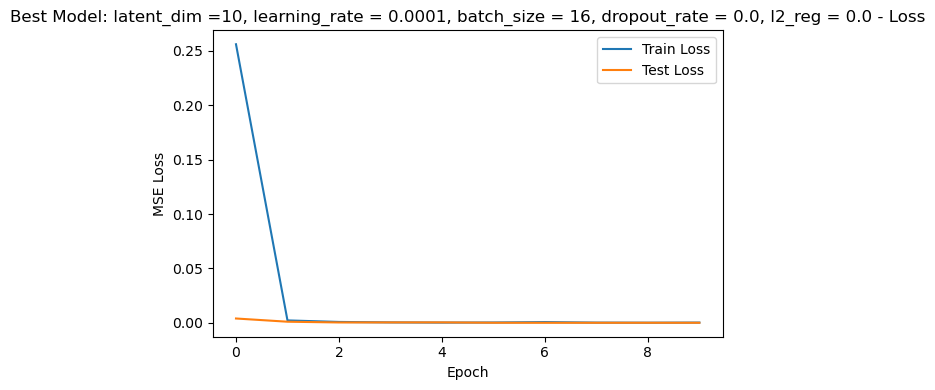

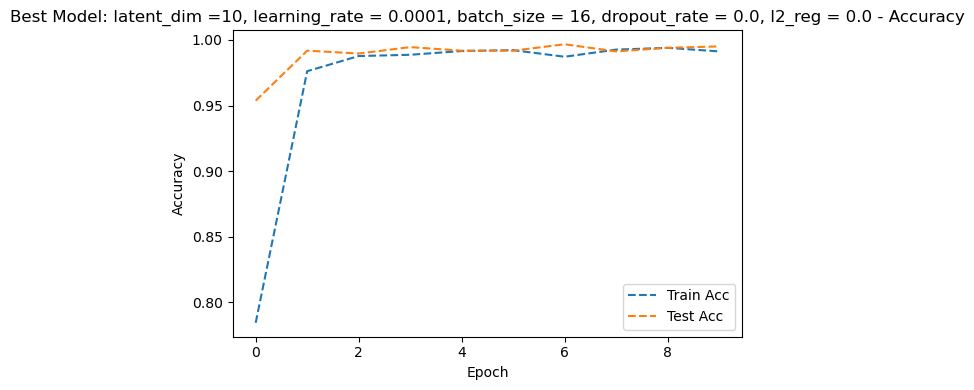

288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
AE latent shape: (9190, 10)
Silhouette score (3D): 0.2033


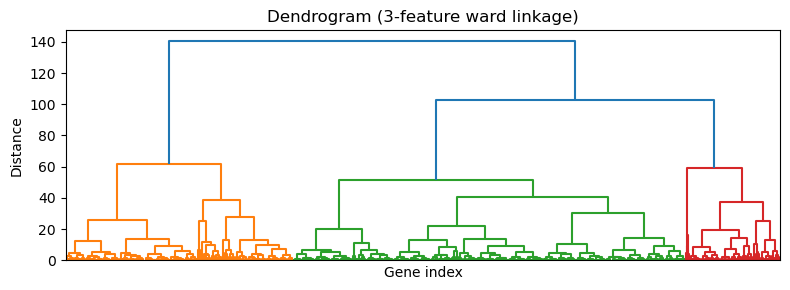

In [357]:
# retrain best model and plot metrics
best_model, _ = train_and_eval(best_params, plot = True)

# extract latents with best model
encoder = models.Model(best_model.input, best_model.get_layer('latent_space').output)
Z_ae = encoder.predict(X)
print("AE latent shape:", Z_ae.shape)

# hierarchical clustering
n_clusters = 100 
hc = AgglomerativeClustering(n_clusters = n_clusters, metric = 'euclidean', linkage = 'ward')
labels = hc.fit_predict(X)

sil_score = silhouette_score(Z_ae, labels)
print(f"Silhouette score (3D): {sil_score:.4f}")

# dendrogram to visualize cluster hierarchy
linked = linkage(X, method = 'ward')
plt.figure(figsize = (8, 3))
dendrogram(linked, no_labels = True, color_threshold = None, distance_sort = 'ascending')
plt.title('Dendrogram (3-feature ward linkage)')
plt.xlabel('Gene index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

PCA silhouette: 0.2724


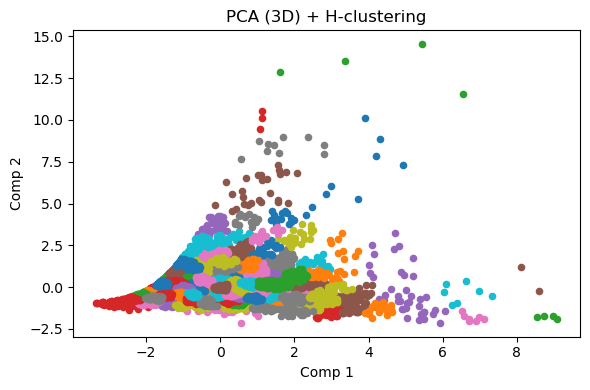

t-SNE silhouette: 0.3177


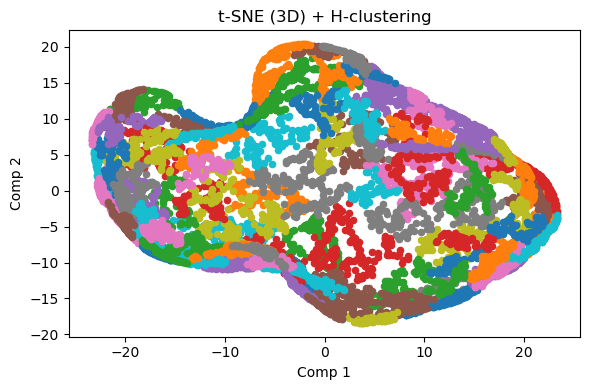

UMAP silhouette: 0.3964


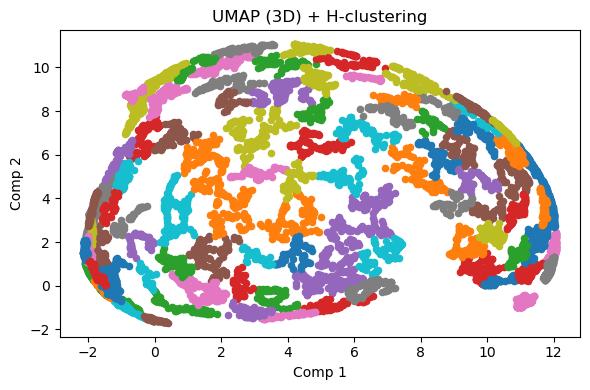

In [359]:
# determine if autoenc outperforms/complements PCA, t-SNE, UMAP

# PCA
Z_pca = PCA(n_components = 3).fit_transform(X)
labels_pca = AgglomerativeClustering(n_clusters = n_clusters).fit_predict(Z_pca)
sil_pca = silhouette_score(Z_pca, labels_pca)
print(f"PCA silhouette: {sil_pca:.4f}")
plot_clusters(Z_pca, labels_pca, title = "PCA (3D) + H-clustering")

# t-SNE
Z_tsne = TSNE(n_components = 3, perplexity = 30).fit_transform(X)
labels_tsne = AgglomerativeClustering(n_clusters = n_clusters).fit_predict(Z_tsne)
sil_tsne = silhouette_score(Z_tsne, labels_tsne)
print(f"t-SNE silhouette: {sil_tsne:.4f}")
plot_clusters(Z_tsne, labels_tsne, title = "t-SNE (3D) + H-clustering")

# UMAP
Z_umap = UMAP(n_components = best_params['latent_dim']).fit_transform(X)
labels_umap = AgglomerativeClustering(n_clusters = n_clusters).fit_predict(Z_umap)
sil_umap = silhouette_score(Z_umap, labels_umap)
print(f"UMAP silhouette: {sil_umap:.4f}")
plot_clusters(Z_umap, labels_umap, title = "UMAP (3D) + H-clustering")


Clustering performance across embeddings:
        method  silhouette  calinski_harabasz
3         UMAP    0.404538        8534.226497
4    AE + UMAP    0.388964        7193.839464
2        t-SNE    0.317680        4437.691147
0  Autoencoder    0.277079        4971.193908
1          PCA    0.268940        6025.028929


<Figure size 800x400 with 0 Axes>

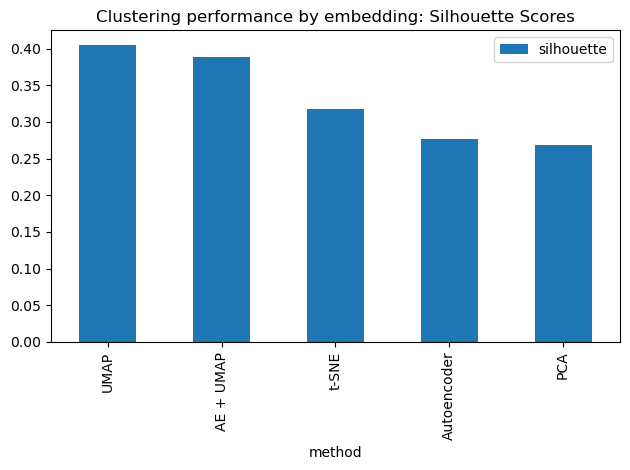

<Figure size 800x400 with 0 Axes>

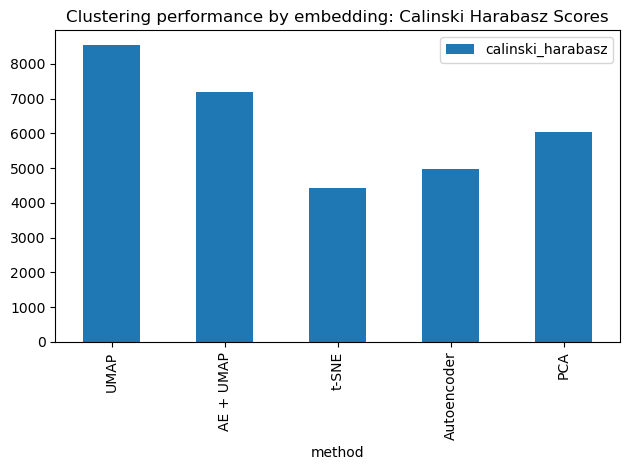

In [361]:
# compare clustering metrics

embeddings = {
    'Autoencoder': Z_ae,
    'PCA': PCA(n_components = 3).fit_transform(X)[:, :2],
    't-SNE': TSNE(n_components = 3).fit_transform(X),
    'UMAP': UMAP(n_components = best_params['latent_dim']).fit_transform(X)
}

n_clusters = 100
scores = []
for name, Z in embeddings.items():
    labels = AgglomerativeClustering(n_clusters = n_clusters).fit_predict(Z)
    sil = silhouette_score(Z, labels)
    ch  = calinski_harabasz_score(Z, labels)
    scores.append({'method': name, 'silhouette': sil, 'calinski_harabasz': ch})

Z_combined = np.hstack([Z_ae, embeddings['UMAP']])
labels_comb = AgglomerativeClustering(n_clusters = n_clusters).fit_predict(Z_combined)
sil_comb = silhouette_score(Z_combined, labels_comb)
ch_comb  = calinski_harabasz_score(Z_combined, labels_comb)
scores.append({'method': 'AE + UMAP', 'silhouette': sil_comb, 'calinski_harabasz': ch_comb})

compare_df = pd.DataFrame(scores).sort_values('silhouette', ascending = False)
print("\nClustering performance across embeddings:")
print(compare_df)

# silhouette bar plot
plt.figure(figsize = (8, 4))
compare_df.set_index('method')[['silhouette']].plot(kind = 'bar')
plt.title('Clustering performance by embedding: Silhouette Scores')
plt.tight_layout()
plt.show()

# calinski bar plot
plt.figure(figsize = (8, 4))
compare_df.set_index('method')[['calinski_harabasz']].plot(kind = 'bar')
plt.title('Clustering performance by embedding: Calinski Harabasz Scores')
plt.tight_layout()
plt.show()